# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [2]:
### Preprocessing requirements
import pandas as pd
# 1. Copy all .h5 and .mzML files from the job folders to a single output directory for easier access.
# 2. Run the deconvolution to make <filename>_deconvoluted.parquet files.
import os
import numpy as np
from scipy.stats import ttest_ind
# import ztest
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
cols = [ 'dbe', 'dbe_ai',
       'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c', 'o_to_c', 'n_to_c',
       'p_to_c', 'c', 'h', 'o', 'n', 's', 'p', 'original_index','precursor_mz','inchi_key', 'compound_name', 'smiles','NPC#pathway', 'NPC#superclass', 'NPC#class','predicted_formula']
node_data = node_data['nodes'][cols]

cols = ['original_index','predicted_unchanged_in_soil_prob', 'predicted_unchanged_in_soil']
model_data = pd.read_csv('../envnet/data/node_data_with_predicted_unchanged_20251107.csv', usecols=cols)
node_data = node_data.merge(model_data, on='original_index', how='left')

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes


In [14]:
import networkx as nx
G = nx.read_graphml(os.path.join(ref_dir, "network_with_sirius.graphml"))

## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [ ]:

# mz_ppm_tolerance = 5
# peak_height_min = 1e4
# num_datapoints_min = 10
# # minimum MSMS score 
# msms_score_min = 0.5


# # minimum MSMS matching ion count
# msms_matches_min = 3

# # retention time range in minutes for feature finding
# rt_range = [1, 700]

# # tolerance in daltons used for calculating MS/MS similarity scores
# frag_mz_tolerance = 0.05

In [ ]:
# from importlib import reload
# at = reload(at)

In [4]:
usecols = [ 'permanent_index','label', 'adduct', 'polarity', 'mz',
       'rt_peak', 'file_name',  'experiment', 'inchi', 'name']
df = pd.read_csv('https://github.com/biorack/metatlas-data/blob/main/C18/production/C18_EMA-standards_negative.tsv?raw=true', sep='\t', usecols=usecols)
from rdkit.Chem import InchiToInchiKey
df['inchikey'] = df.inchi.apply(InchiToInchiKey)
df

,permanent_index,label,adduct,polarity,mz,rt_peak,file_name,experiment,inchi,name,inchikey
0,79741,AMINOCAPROIC ACID HYDROCHLORIDE,[M-H]-,negative,130.087353,0.529585,/global/cfs/cdirs/metatlas/raw_data/jgi/202504...,NaN,"InChI=1S/C6H13NO2/c7-5-3-1-2-4-6(8)9/h1-5,7H2,...",AMINOCAPROIC ACID HYDROCHLORIDE,SLXKOJJOQWFEFD-UHFFFAOYSA-N
1,79742,ALENDRONATE SODIUM TRIHYDRATE,[M-H]-,negative,248.009449,0.529932,/global/cfs/cdirs/metatlas/raw_data/jgi/202504...,NaN,"InChI=1S/C4H13NO7P2/c5-3-1-2-4(6,13(7,8)9)14(1...",ALENDRONATE SODIUM TRIHYDRATE,OGSPWJRAVKPPFI-UHFFFAOYSA-N
2,27804,glyceraldehyde,[M-H]-,negative,89.024394,0.539409,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,"InChI=1S/C3H6O3/c4-1-3(6)2-5/h1,3,5-6H,2H2",glyceraldehyde,MNQZXJOMYWMBOU-UHFFFAOYSA-N
3,34952,lactic acid,[M-H]-,negative,89.024394,0.539459,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,"InChI=1S/C3H6O3/c1-2(4)3(5)6/h2,4H,1H3,(H,5,6)...",L-Lactic acid,JVTAAEKCZFNVCJ-REOHCLBHSA-N
4,28627,dtdp-alpha-glucose,[M-H]-,negative,563.068456,0.548620,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,InChI=1S/C16H26N2O16P2/c1-6-3-18(16(25)17-14(6...,dTDP-alpha-D-glucose,YSYKRGRSMLTJNL-URARBOGNSA-N
...,...,...,...,...,...,...,...,...,...,...,...
2923,34454,nervonic acid,[M-H]-,negative,365.342481,8.924247,20190108_KBL_TN_EMA_MSMLS_Plt5n7_QE-HF_C18_USD...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,InChI=1S/C24H46O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,Nervonic acid,GWHCXVQVJPWHRF-KTKRTIGZSA-N
2924,73408,8-((1e)-4-cyclohex-1-enyl-2-azabut-1-enyl)-2-[...,[M-H]-,negative,731.406538,8.945223,20190315_KBL-AK_TN_EMA_TimTec-NPL3000_PL1to38_...,20190312_KBL_TN_EMA_TimTecNDL3000_Plates1to38_...,InChI=1S/C46H56N2O6/c1-25(2)35-31-21-27(5)37(4...,8-((1E)-4-cyclohex-1-enyl-2-azabut-1-enyl)-2-[...,WHTFMDSWOMRPEZ-AXITZHBMSA-N
2925,19638,valinomycin,[M+Cl]-,negative,1145.600560,8.998985,20190115_KBL_TN_EMA_Enzo_Pl1to6_QE-HF_C18_USDA...,20190115_KBL_TN_Enzo_Pl1to6_QE-HF_C18_USDAY46918,InChI=1S/C54H90N6O18/c1-22(2)34-49(67)73-31(19...,valinomycin,FCFNRCROJUBPLU-DNDCDFAISA-N
2926,36658,1-({[2-(2-furylmethyl)cyclohexyl]amino}methyle...,[M-H]-,negative,839.427667,9.048340,20190315_KBL-AK_TN_EMA_TimTec-NPL3000_PL1to38_...,20190312_KBL_TN_EMA_TimTecNDL3000_Plates1to38_...,InChI=1S/C52H60N2O8/c1-27(2)41-35-21-29(5)43(4...,1-({[2-(2-furylmethyl)cyclohexyl]amino}methyle...,VNTAPYBNVBWZQH-MEDPLMNLSA-N


In [23]:
node_data.loc[node_data['original_index']==2430467]

,dbe,dbe_ai,dbe_ai_mod,ai_mod,ai,nosc,h_to_c,o_to_c,n_to_c,p_to_c,...,precursor_mz,inchi_key,compound_name,smiles,NPC#pathway,NPC#superclass,NPC#class,predicted_formula,predicted_unchanged_in_soil_prob,predicted_unchanged_in_soil
16331,10.0,2.0,5.0,0.416667,0.222222,0.0,1.058824,0.352941,0.117647,0.0,...,345.109429,NaN,NaN,NaN,Alkaloids,Anthranilic acid alkaloids,Pyrrolidine alkaloids,C17H18N2O6,0.992078,1


In [10]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
ms1_filename = os.path.join(data_path,'ms1_results','ms1_annotations.parquet')
ms2_filename = os.path.join(data_path,'ms2_results','ms2_deconvoluted_annotations.parquet')
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

In [21]:
permafrost_ms2_df['score_deconvoluted_match'].min()

0.5000018089562575

In [19]:
permafrost_ms1_df = pd.read_parquet(ms1_filename)
permafrost_ms2_df = pd.read_parquet(ms2_filename)
permafrost_analysis_df = pd.read_csv(analysis_filename)#,usecols=cols)

permafrost_ms1_df.loc[permafrost_ms1_df['peak_area']>1e7,'original_index'].nunique(),permafrost_analysis_df['original_index'].nunique(),permafrost_ms2_df['original_index_deconvoluted_match'].nunique()


(13470, 21129, 2268)

In [6]:

cols = """inchi_key_identity
name_identity
ms2_score
ms2_matches
mz_centroid
rt_peak
p_value
t_score
log2_foldchange"""
cols = cols.split('\n')
output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')
output = output[output['inchi_key'].isin(df.inchikey)]
output = output[output['p_value'] < 0.05]
# output = output[output['ms2_matches'] > msms_matches_min]
# output = pd.merge(output, df, left_on='inchi_key_identity', right_on='inchikey', how='inner')
output.sort_values('log2_foldchange', ascending=False, inplace=True)
output.to_csv('output.csv', index=False)
output

NameError: name 'df' is not defined

In [ ]:
# cols = """inchi_key_identity
# name_identity
# ms2_score
# ms2_matches
# mz_centroid
# rt_peak
# peak_area
# peak_height
# p_value
# t_score
# log2_foldchange
# mean-20M
# std_dev-20M
# mean-55M
# std_dev-55M"""
# cols = cols.split('\n')
# output = pd.read_csv('Permafrost_-_20M_vs._55M_Norm-7be99f94122347c388b9cee5d8008436-output_group1-vs-group2.csv',usecols=cols)
# sum((output['ms2_matches']>2) & (output['ms2_score']>0.7)), sum(output['peak_area']>1e6)

(2480, 10359)

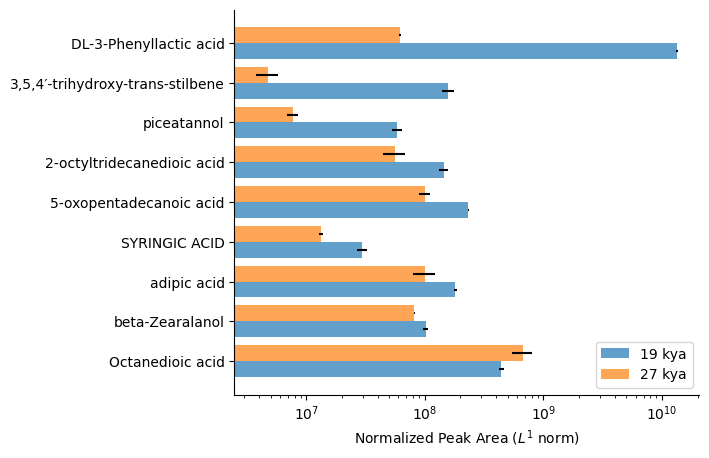

In [7]:
# running a targeted analysis, yielded this list of inchikeys
passing_inchikeys = """WNLRTRBMVRJNCN-UHFFFAOYSA-N
JMSVCTWVEWCHDZ-UHFFFAOYSA-N
FJKROLUGYXJWQN-UHFFFAOYSA-N
VOXXWSYKYCBWHO-UHFFFAOYSA-N
RHMXXJGYXNZAPX-UHFFFAOYSA-N
KXGVEGMKQFWNSR-LLQZFEROSA-N
LUKBXSAWLPMMSZ-OWOJBTEDSA-N
KGDFFRUWAGMXRB-UHFFFAOYSA-N
TYFQFVWCELRYAO-UHFFFAOYSA-N
DWTTZBARDOXEAM-JSGCOSHPSA-N
CDRPUGZCRXZLFL-OWOJBTEDSA-N
RNMOYYIVANEQIG-UHFFFAOYSA-N"""
passing_inchikeys = passing_inchikeys.split('\n')
# cols = """inchi_key_identity
# name_identity
# ms2_score
# ms2_matches
# mz_centroid
# rt_peak
# p_value
# t_score
# log2_foldchange
# mean-20M
# std_dev-20M
# mean-55M
# std_dev-55M"""
# cols = cols.split('\n')
# output = pd.read_csv('Permafrost_-_20M_vs._55M_Norm-7be99f94122347c388b9cee5d8008436-output_group1-vs-group2.csv',usecols=cols)
output = output[output['inchi_key'].isin(passing_inchikeys)]
output = output[output['p_value'] < 0.05]
# output = output[output['ms2_matches'] > msms_matches_min]
# output = pd.merge(output, df, left_on='inchi_key_identity', right_on='inchikey', how='inner')
output.sort_values('log2_foldchange', ascending=False, inplace=True)

# rename the compound with name_identity
new_name = '3,5,4′-trihydroxy-trans-stilbene'
old_name = '501-36-0'
output['compound_name'] = output['compound_name'].replace(old_name, new_name)

output.drop_duplicates('inchi_key', inplace=True)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
# make an errorbar chart
output['mean-20M'] = output['mean-20M'].astype(float)
output['mean-55M'] = output['mean-55M'].astype(float)
output['std_dev-20M'] = output['std_dev-20M'].astype(float)
output['std_dev-55M'] = output['std_dev-55M'].astype(float)
compound_labels = output['compound_name']
x = np.arange(len(compound_labels))
# make horizontal error bar plot
# Create horizontal bar chart with error bars
# Define bar width and offset
bar_width = 0.4
offset = bar_width / 2

# Create horizontal bar chart with error bars
ax.barh(x - offset, output['mean-20M'], xerr=output['std_dev-20M'], height=bar_width, align='center', alpha=0.7, label='19 kya')
ax.barh(x + offset, output['mean-55M'], xerr=output['std_dev-55M'], height=bar_width, align='center', alpha=0.7, label='27 kya')

ax.set_yticks(x)
ax.set_yticklabels(compound_labels)

ax.set_xlabel(r'Normalized Peak Area ($\mathit{L}^{1}$ norm)')
# ax.set_ylabel('Compound')

# remove top and bottom plot lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xscale('log')
ax.legend()
# ax.grid()
plt.show()

Index(['Unnamed: 0', 'NPC#class', 'mean', 'stderror', 'count',
       'positive_count', 'negative_count', 'binomial_pvalue'],
      dtype='object')


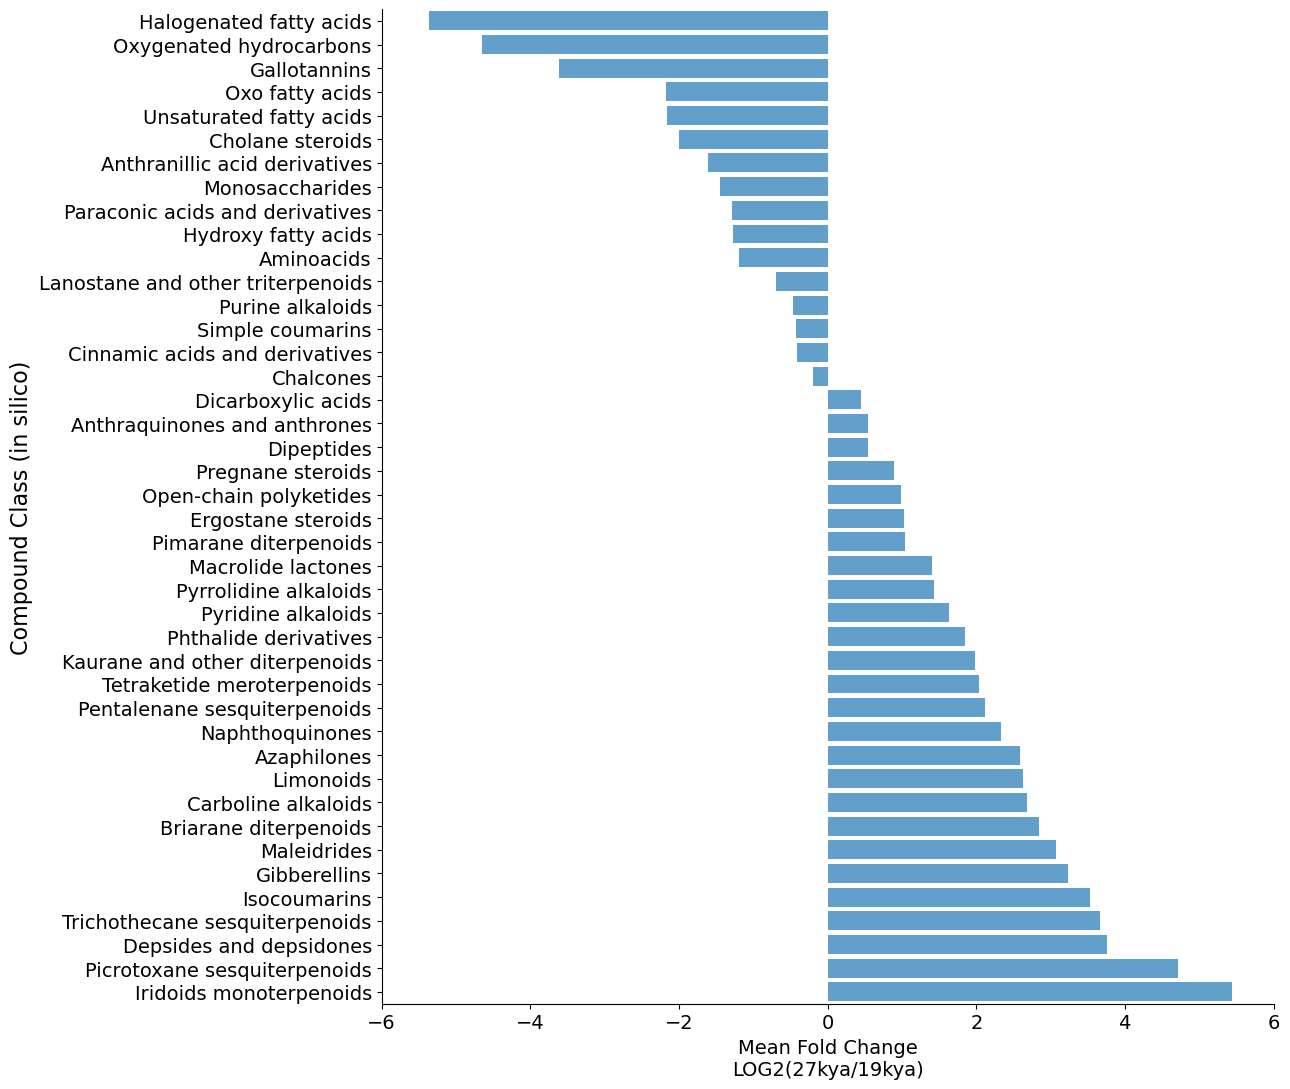

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
class_analysis_filename = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/permafrost results gnps2/analysis_results/class_output_csv/NPC#class_enrichment.csv'
df = pd.read_csv(class_analysis_filename)
print(df.columns)
# df = df[abs(df['mean'])>1]
df = df[df['count']>50]
fig,ax = plt.subplots(figsize=(13,11))
compound_labels = df['NPC#class']
# shorted compound labels
shorten_dict = {'Lanostane, Tirucallane and Euphane triterpenoids':'Lanostane and other triterpenoids',
                'Kaurane and Phyllocladane diterpenoids':'Kaurane and other diterpenoids',
                'Pimarane and Isopimarane diterpenoids':'Pimarane diterpenoids'}
compound_labels = compound_labels.replace(shorten_dict)
x = np.arange(len(compound_labels))
y = df['mean']
yerr = df['stderror']
ax.barh(x, y,align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(x)
ax.set_yticklabels(compound_labels, rotation=0, ha='right')
# ax.set_xlabel('Propagated Class',fontsize=20)
ax.set_xlabel('Mean Fold Change\nLOG2(27kya/19kya)',fontsize=14)
# change font of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Compound Class (in silico)',fontsize=16)
# ax.grid()
ax.set_xlim(-6,6)
ax.set_ylim(x.min()-0.5,x.max()+0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx

# sys.path.insert(0,'/global/homes/b/bpb/repos/envnet/envnet/use')
# import analysis_tools as at

# df = pd.read_csv('../../data/output_group1-vs-group2.csv')
# df['envnet_node_id'] = df['envnet_node_id'].astype(str)
# # G = nx.read_graphml('../../data/envnet.graphml')
# G = nx.read_graphml('../../data/AnnotatedENVnet.graphml')
# # node_data = at.graph_to_df()


In [ ]:

# node_data = node_data.dropna(subset=['smiles_identity'])
# smiles = list(set(node_data['smiles_identity'].tolist()))
# from rdkit.Chem import MolFromSmiles
# mols = [MolFromSmiles(s) for s in smiles]


# from rdkit.Chem import MolFromSmarts
# pat = '[$([C]([#6])([#6])([#6])[#6])]'
# # find the smarts substructure in the molecules
# quat_pat = MolFromSmarts(pat)
# # count the substructure matches in each molecule
# num_quat = np.array([len(mol.GetSubstructMatches(quat_pat)) for mol in mols])
# # count the number of total Carbon atoms in each molecule
# sorted_idx = np.argsort(num_quat)[::-1]
# sorted_idx = sorted_idx[:20]
# top_smiles = [smiles[i] for i in sorted_idx]
# nodes_we_want = node_data.loc[node_data['smiles_identity'].isin(top_smiles),'node_id'].to_list()

# bottom_idx = np.argwhere(num_quat == 0).flatten()
# bottom_smiles = [smiles[i] for i in bottom_idx]
# low_nodes = node_data.loc[node_data['smiles_identity'].isin(bottom_smiles),'node_id'].to_list()


In [14]:
# fig,ax = plt.subplots(
# )
# ax.plot(df['mean-19 kya'],df['mean-27 kya'],'.',label='All',alpha=0.5)

# idx = node_data['high_quaternary_propagated'] == "Neighbors of three or more quaternary Carbons"
# nodes = node_data.loc[idx,'node_id'].tolist()
# ax.plot(df.loc[df['envnet_node_id'].isin(nodes),'mean-19 kya'],df.loc[df['envnet_node_id'].isin(nodes),'mean-27 kya'],'.',label='Neighbors of >3 quat. Carbon')

# idx = node_data['high_quaternary'] == "Three or more quaternary Carbons"
# nodes = node_data.loc[idx,'node_id'].tolist()
# # ['mean-20M', 'mean-55M']
# ax.plot(df.loc[df['envnet_node_id'].isin(nodes),'mean-19 kya'],df.loc[df['envnet_node_id'].isin(nodes),'mean-27 kya'],'k.',label='3 or more quat. Carbon atoms')
# ax.plot([1e4,1e8],[1e4,1e8],'k--')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('19 kya')
# ax.set_ylabel('29 kya')
# # legend with no box
# ax.legend(frameon=False)

# ax.axes.set_aspect('equal')
# ax.set_xlim(1e4,1e10)
# ax.set_ylim(1e4,1e10)

In [15]:
# [c for c in df.columns if 'score' in c]

# Find out which identity node has the most old permafrost nodes neighboring it

In [9]:
import networkx as nx
graphml_filename = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/permafrost results gnps2/analysis_results/envnet_network_annotated.graphml'
G = nx.read_graphml(graphml_filename)

data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

In [24]:
ms2_df = pd.read_parquet(ms2_filename)
nodes_with_ms2 = ms2_df['original_index_deconvoluted_match'].tolist()
idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)# & (pd.notna(output['inchi_key']))
node_increased_27kya = output.loc[idx,'original_index'].astype(int).tolist()

idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
# idx = (idx) & (pd.notna(output['inchi_key']))
node_with_id_increased_19kya = output.loc[idx,'original_index'].astype(int).tolist()

my_nodes = node_increased_27kya + node_with_id_increased_19kya
my_nodes = list(set(my_nodes))
my_nodes = list(set(my_nodes) & set(nodes_with_ms2))

print(f"Number of nodes: {len(my_nodes)}")


# Now filter edges based on original_index values
edges = G.edges()
print(f"Total edges in graph: {len(edges)}")

edges = G.edges()
# remove all edges that do not have a node_with_id increased in 19kya
edges = [(u,v) for u,v in edges if int(u) in my_nodes or int(v) in my_nodes]
print(f"Filtered edges in graph: {len(edges)}")

Number of nodes: 1711
Total edges in graph: 390714
Filtered edges in graph: 141799
Filtered edges in graph: 141799


In [25]:
# cols = ['original_index', 'p_value', 'log2_foldchange',
#         'inchi_key', 'compound_name',
#        'predicted_formula']
# df = pd.merge(pd.DataFrame(edges,columns=['source','target']).astype(int),output[cols].add_suffix('_source'),left_on='source',right_on='original_index_source',how='left')
# df = pd.merge(df,output[cols].add_suffix('_target'),left_on='target',right_on='original_index_target',how='left')


In [10]:
from copy import deepcopy
cols = ['original_index', 'p_value', 'log2_foldchange',
        'inchi_key', 'compound_name',
       'predicted_formula']

df = pd.merge(pd.DataFrame(edges,columns=['source','target']).astype(int),output[cols].add_suffix('_source'),left_on='source',right_on='original_index_source',how='left')
df = pd.merge(df,output[cols].add_suffix('_target'),left_on='target',right_on='original_index_target',how='left')
# df = df[df['predicted_formula_source'].str.contains('C10')]
g = df[pd.notna(df['inchi_key_source'])].groupby('source').agg({'log2_foldchange_source':'median','target':'count'})
g.sort_values('log2_foldchange_source',ascending=True,inplace=True)
g = pd.merge(g,node_data,left_index=True,right_on='original_index')
g = g[g['target']>8]

# Store the original edges to avoid modification issues
original_edges = list(edges)  # Make a copy of the edges list
list_of_graphs = []
for i,row in g.head(100).iterrows():
    print(f"{row['compound_name']}: {row['log2_foldchange_source']:.2f} ({row['target']} connections)")
    # make an ego graph for "original_index" node this needs to be a deep copy so as to not modify the original graph
    partial_G = deepcopy(G)
    ego = nx.ego_graph(partial_G, str(row['original_index']), radius=1)
    print(f"  Ego graph has {ego.number_of_nodes()} nodes and {ego.number_of_edges()} edges")
    
    # Remove edges between neighboring nodes, keep only edges connected to the ego node (hub)
    ego_node = str(row['original_index'])
    edges_to_remove = []
    for u, v in ego.edges():
        # Remove edge if neither node is the ego node (i.e., it's an edge between neighbors)
        if u != ego_node and v != ego_node:
            edges_to_remove.append((u, v))
    
    ego.remove_edges_from(edges_to_remove)
    print(f"  After removing neighbor-to-neighbor edges: {ego.number_of_nodes()} nodes and {ego.number_of_edges()} edges")
    
    basedir = graphml_filename.rsplit('/',1)[0]
    sub_folder = "ego_graphs"
    sub_folder = os.path.join(basedir,sub_folder)
    if not os.path.exists(sub_folder):
        os.makedirs(sub_folder)
    ego_filename = f"ego_graph_node_{row['original_index']}.graphml"
    ego_filename = os.path.join(sub_folder, ego_filename)
    nx.write_graphml(ego, ego_filename)
    print(f"Saved ego graph to {ego_filename}")
    list_of_graphs.append(ego)
# merge the list of graphs into a single graph
merged_graph = nx.compose_all(list_of_graphs)
merged_graph_filename = os.path.join(sub_folder, "merged_ego_graphs.graphml")
nx.write_graphml(merged_graph, merged_graph_filename)
print(f"Saved merged ego graph to {merged_graph_filename}")

NameError: name 'edges' is not defined

In [11]:
temp.columns

Index(['original_index', 'mean-20M', 'mean-55M', 'median-20M', 'median-55M',
       'standard_error-20M', 'standard_error-55M', 'std_dev-20M',
       'std_dev-55M', 'p_value', 't_score', 'log2_foldchange',
       'peak_values_normalized', 'peak_value_used', 'control_group',
       'treatment_group', 'precursor_mz', 'inchi_key', 'compound_name',
       'smiles', 'NPC#pathway', 'NPC#superclass', 'NPC#class',
       'predicted_formula', 'predicted_unchanged_in_soil',
       'predicted_unchanged_in_soil_prob'],
      dtype='object')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)

# NOTE: The 'node_data' DataFrame needs to be loaded or defined before this line.
# For example: node_data = pd.read_csv('path/to/your/node_data.csv')
# As a placeholder, let's assume node_data is an empty DataFrame if it doesn't exist
if 'node_data' not in locals():
    print("Warning: 'node_data' not found. Creating an empty DataFrame.")
    # This assumes 'original_index' is the merge key. Adjust if necessary.
    node_data = pd.DataFrame({'original_index': output['original_index'].unique()})


output = pd.merge(output, node_data, on='original_index', how='left')

In [4]:
output.columns

Index(['original_index', 'mean-20M', 'mean-55M', 'median-20M', 'median-55M',
       'standard_error-20M', 'standard_error-55M', 'std_dev-20M',
       'std_dev-55M', 'p_value', 't_score', 'log2_foldchange',
       'peak_values_normalized', 'peak_value_used', 'control_group',
       'treatment_group', 'precursor_mz', 'inchi_key', 'compound_name',
       'smiles', 'NPC#pathway', 'NPC#superclass', 'NPC#class',
       'predicted_formula', 'predicted_unchanged_in_soil_prob',
       'predicted_unchanged_in_soil'],
      dtype='object')

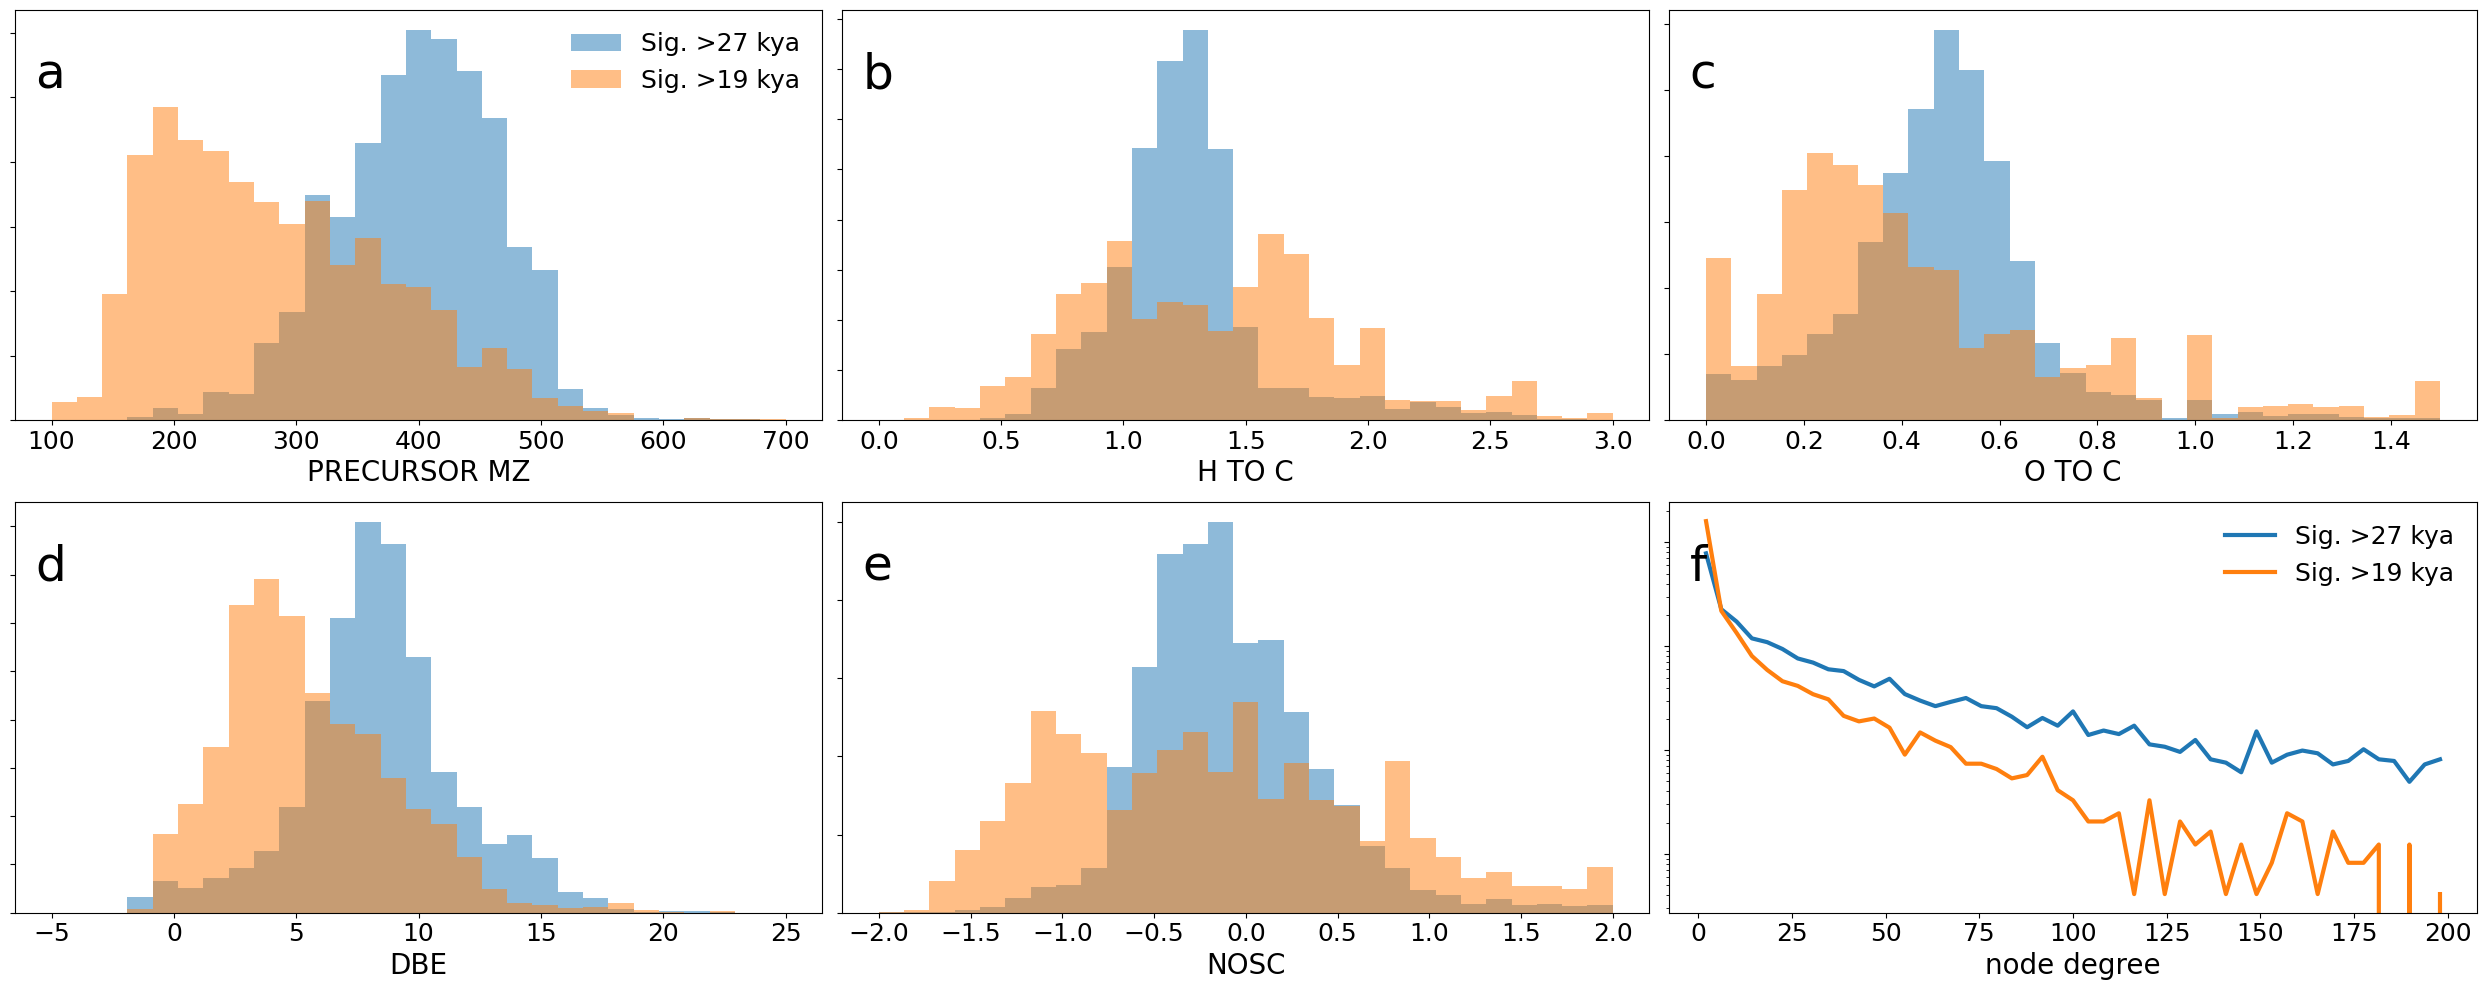

In [22]:
# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)

# NOTE: The 'node_data' DataFrame needs to be loaded or defined before this line.
# For example: node_data = pd.read_csv('path/to/your/node_data.csv')
# As a placeholder, let's assume node_data is an empty DataFrame if it doesn't exist
if 'node_data' not in locals():
    print("Warning: 'node_data' not found. Creating an empty DataFrame.")
    # This assumes 'original_index' is the merge key. Adjust if necessary.
    node_data = pd.DataFrame({'original_index': output['original_index'].unique()})


output = pd.merge(output, node_data, on='original_index', how='left')

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(25, 10))

gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
# ax7 = fig.add_subplot(gs[2, 0])
# ax8 = fig.add_subplot(gs[2, 1])
# ax9 = fig.add_subplot(gs[2, 2])



# Example usage: plot something on each subplot
ax = [ax1, ax2, ax3, ax4, ax5, ax6]#, ax7, ax8, ax9]
counter = 0
terms = [('precursor_mz',100,700),('h_to_c',0,3),('o_to_c',0,1.5),('dbe',-5,25),('nosc',-2,2)]
for term in terms:
    edges = np.linspace(term[1],term[2],30)
    idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)
    ax[counter].hist(output.loc[idx,term[0]],bins=edges,alpha=0.5,label='Sig. >27 kya',density=True)

    idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
    ax[counter].hist(output.loc[idx,term[0]],bins=edges,alpha=0.5,label='Sig. >19 kya',density=True)
    ax[counter].set_xlabel(term[0].replace('envnet','').replace('_',' ').upper(),fontsize=20)
    if counter == 0:
        ax[counter].legend(fontsize=18,frameon=False)
    # ax[counter].legend()
    ax[counter].set_yticklabels([])
    # increase fontsize of x tick labels
    ax[counter].tick_params(axis='x', labelsize=18)
    counter += 1

edges = np.linspace(0,200,50)
idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)
up_nodes = output.loc[idx,'original_index'].to_list()
# histogram the node degree of the nodes we want
degrees = [G.degree(str(n)) for n in up_nodes]
# ax[counter].hist(degrees,bins=edges,alpha=0.5,label='Sig. >27 kya',density=True,cumulative=False)
y_data,x_data = np.histogram(degrees,bins=edges,density=True)
x_data = (x_data[1:] + x_data[:-1])/2
ax[counter].plot(x_data,y_data,'-',label='Sig. >27 kya',linewidth=3)

idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
down_nodes = output.loc[idx,'original_index'].to_list()
# histogram the node degree of the nodes we want
degrees = [G.degree(str(n)) for n in down_nodes]
# ax[counter].hist(degrees,bins=edges,alpha=0.5,label='Sig. >19 kya',density=True,cumulative=False)
y_data,x_data = np.histogram(degrees,bins=edges,density=True)
x_data = (x_data[1:] + x_data[:-1])/2
ax[counter].plot(x_data,y_data,'-',label='Sig. >19 kya',linewidth=3)
ax[counter].set_xlabel('node degree',fontsize=20)

ax[counter].legend(fontsize=18,frameon=False)
ax[counter].set_yscale('log')
ax[counter].tick_params(axis='x', labelsize=18)
# ax[counter].tick_params(axis='y', labelsize=18)
ax[counter].set_yticklabels([])
counter += 1

# add a,b,c
for i, label in enumerate(('a', 'b', 'c', 'd', 'e', 'f')):
    ax[i].text(0.025, 0.9, label, transform=ax[i].transAxes,
            fontsize=35, va='top')


plt.tight_layout()


plt.show()

(0.0, 0.07)

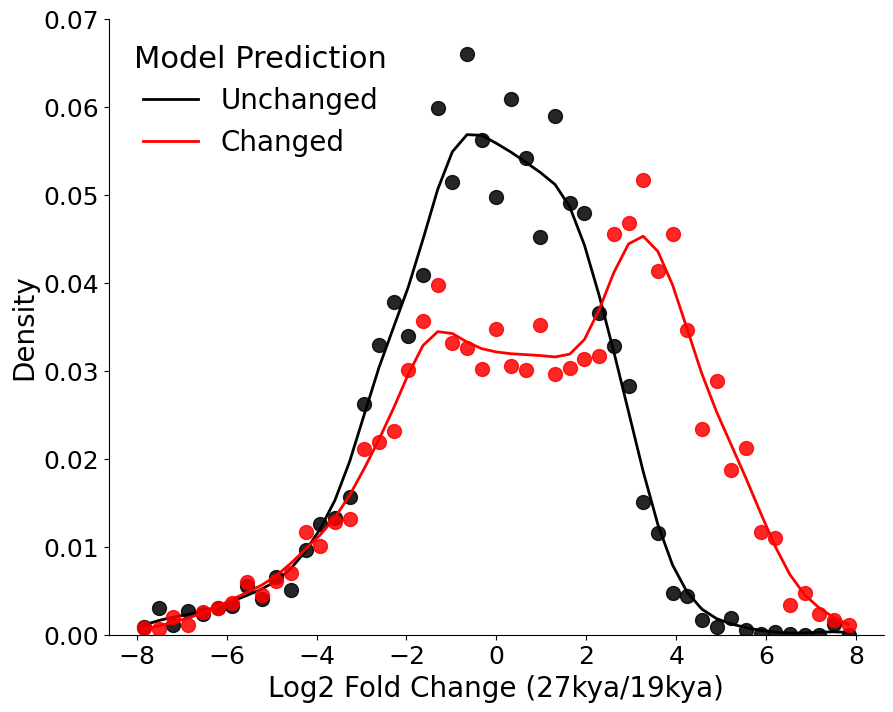

In [11]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

fig,ax = plt.subplots(figsize=(10, 8))
temp = output.copy()
temp = output[pd.notna(temp['log2_foldchange'])]
temp = temp[pd.notna(temp['predicted_unchanged_in_soil_prob'])]

# temp = df[pd.notna(temp['ms2_score'])]
idx_identified = (temp['predicted_unchanged_in_soil']==1)
edges = np.linspace(-8,8,50)
# ax.hist(df.loc[idx_identified,'log2_foldchange'],bins=edges,label='Has Library Match',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth
pat = np.exp(-x**2/(2*0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'k.',alpha=0.85,markersize=20)
ax.plot(x,smooth_y,'k-',label='Unchanged',alpha=1,linewidth=2)
# ax.hist(df['log2_foldchange'],bins=edges,label='All Nodes',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[~idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth

smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'r.',alpha=0.85,markersize=20)
ax.plot(x,smooth_y,'r-',label='Changed',alpha=1,linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log2 Fold Change (27kya/19kya)',fontsize=20)
ax.set_ylabel('Density',fontsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=20,loc='upper left',title='Model Prediction',title_fontsize=22)
ax.set_ylim(0,0.07)


(0.0, 0.1)

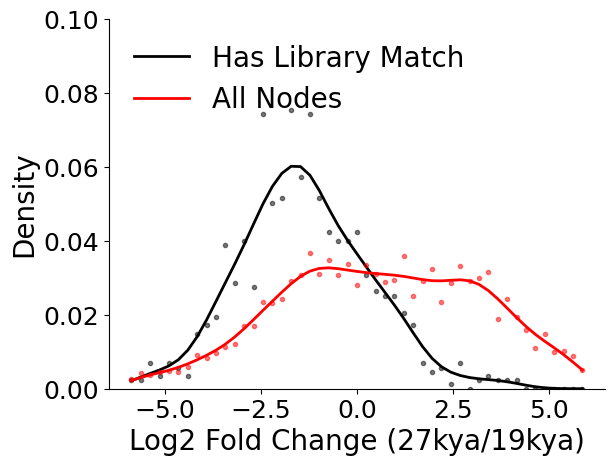

In [ ]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

fig,ax = plt.subplots(figsize=(10,8))
temp = output.copy()
temp = output[pd.notna(temp['log2_foldchange'])]
# temp = df[pd.notna(temp['ms2_score'])]
idx_identified = (pd.notna(temp['inchi_key']))# & (pd.notna(df['ms2_score'])) #& (df['p_value'] < 0.05)
edges = np.linspace(-6,6,50)
# ax.hist(df.loc[idx_identified,'log2_foldchange'],bins=edges,label='Has Library Match',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth
pat = np.exp(-x**2/(2*0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'k.',alpha=0.5)
ax.plot(x,smooth_y,'k-',label='Has Library Match',alpha=1,linewidth=2)
# ax.hist(df['log2_foldchange'],bins=edges,label='All Nodes',alpha=0.5,density=True)
y,x = np.histogram(temp['log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth

smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'r.',alpha=0.5)
ax.plot(x,smooth_y,'r-',label='All Nodes',alpha=1,linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log2 Fold Change (27kya/19kya)',fontsize=20)
ax.set_ylabel('Density',fontsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=20,loc='upper left')
ax.set_ylim(0,0.1)